# Dx(Diagnosis), Px(Procedures)

---

# Results1: attention score

## base setting

In [1]:
import os
import sys 
import easydict

from tqdm import tqdm

In [2]:
EXP_PATH = '/home/ssbae/bae/kg_txt_multimodal/lxmert'
sys.path.append(EXP_PATH + '/src')

In [3]:
from transformers import LxmertTokenizer, LxmertConfig
from model import LxmertForKGTokPredAndMaskedLM, LxmertForRanking, LxmertForGeneration, LxmertModel

from utils.dataset import get_dataset
from utils.data_collator import NegativeSampling_DataCollator, Evaluation_DataCollator

import torch
from torch.utils.data.sampler import RandomSampler, SequentialSampler
from torch.utils.data import ConcatDataset, DataLoader

In [4]:
MODEL_PATH = 'KGenc_LMinit_H128_L2,2,4_Align_RC_Unified2000_RNG1234'

In [5]:
model_args = easydict.EasyDict({
    "model_name_or_path": os.path.join(EXP_PATH, f'pretrained_models/pretrain/dx,prx/{MODEL_PATH}'),
    "tokenizer_name": 'bert-base-uncased',
    "cache_dir": None,
})

data_args = easydict.EasyDict({
    "eval_data_file": os.path.join(EXP_PATH, "data/dx,prx_2000/dx,prx_UnifiedUniKGenc/valid"),
    "test_data_file": os.path.join(EXP_PATH, "data/dx,prx_2000/dx,prx_UnifiedUniKGenc/test"),
    "block_size": 512,
})

training_args = easydict.EasyDict({
    "per_device_eval_batch_size": 1,
    "task": "pretrain",
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "do_eval": True,
})

### load config, tokenizer, and model

In [6]:
config = LxmertConfig.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
config.use_ce_pooler = True
config.cross_att_type = 'cross'

404 Client Error: Not Found for url: https://huggingface.co//home/ssbae/bae/kg_txt_multimodal/lxmert/pretrained_models/pretrain/dx,prx/KGenc_LMinit_H128_L2,2,4_Align_RC_Unified2000_RNG1234/resolve/main/config.json


OSError: Can't load config for '/home/ssbae/bae/kg_txt_multimodal/lxmert/pretrained_models/pretrain/dx,prx/KGenc_LMinit_H128_L2,2,4_Align_RC_Unified2000_RNG1234'. Make sure that:

- '/home/ssbae/bae/kg_txt_multimodal/lxmert/pretrained_models/pretrain/dx,prx/KGenc_LMinit_H128_L2,2,4_Align_RC_Unified2000_RNG1234' is a correct model identifier listed on 'https://huggingface.co/models'

- or '/home/ssbae/bae/kg_txt_multimodal/lxmert/pretrained_models/pretrain/dx,prx/KGenc_LMinit_H128_L2,2,4_Align_RC_Unified2000_RNG1234' is the correct path to a directory containing a config.json file



In [ ]:
tokenizer = LxmertTokenizer.from_pretrained(model_args.tokenizer_name, cache_dir=model_args.cache_dir)

In [ ]:
# model = LxmertForKGTokPredAndMaskedLM.from_pretrained(model_args.model_name_or_path,
#                                                       config=config)

model = LxmertModel.from_pretrained(model_args.model_name_or_path,
                                    config=config)

### load dataset, data_collator (test)

In [14]:
test_dataset = get_dataset(data_args, 
                           tokenizer=tokenizer, 
                           token_type_vocab=config.token_type_vocab,
                           test=True) if training_args.do_eval else None

100%|██████████| 2000/2000 [00:00<00:00, 11101.43it/s]


In [15]:
data_collator = Evaluation_DataCollator(tokenizer=tokenizer,
                                        kg_special_token_ids=config.kg_special_token_ids,
                                        task=training_args.task)

In [16]:
# model.to(training_args.device)
model.cpu()
model.eval()

LxmertModel(
  (lang_embeddings): LxmertEmbeddings(
    (word_embeddings): Embedding(30522, 128)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (kg_embeddings): LxmertEmbeddings(
    (word_embeddings): Embedding(8057, 128)
    (position_embeddings): Embedding(1024, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): LxmertEncoder(
    (layer): ModuleList(
      (0): LxmertLayer(
        (attention): LxmertSelfAttentionLayer(
          (self): LxmertAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
        

In [17]:
data_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
#     batch_size=training_args.eval_batch_size,
    batch_size=1,
    collate_fn=data_collator,
    pin_memory=True,
    )

## Attention View

### reshaping function

In [18]:
def reshape(x,attn_type):
    if attn_type == 'txt->txt':
        output = [attn[:,:,:len(lang_tokens),:len(lang_tokens)] for attn in x]
    elif attn_type == 'kg->kg':
        output = [attn[:,:,:len(kg_tokens),:len(kg_tokens)] for attn in x]
    elif attn_type == 'txt->kg':
        output = [attn[:,:,:len(lang_tokens),:len(kg_tokens)] for attn in x]
    elif attn_type == 'kg->txt':
        output = [attn[:,:,:len(kg_tokens),:len(lang_tokens)] for attn in x]
    else:
        raise ValueError('Invalid attention type')
    return output

### load visualization tool

In [130]:
from attentionviz import head_view

In [131]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/3.4.8/d3.min',
      jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

### load label dictionary in KG

In [132]:
node2id = torch.load(os.path.join(os.path.dirname(data_args.test_data_file), 'unified_node'))
id2node = {v:k.split('^^')[0] for k,v in node2id.items()}

### get attention score from sample

In [161]:
import matplotlib.pyplot as plt

SAMPLE_IDX = 56

for idx, data in enumerate(data_loader):
    if idx==SAMPLE_IDX:
        input_data = data
        break
        
print('==== Text ====')
temp = input_data['lang_input_ids'].cpu().squeeze()
lang_tokens = tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist())
print('Token seq : {}\n'.format(lang_tokens))
print('Full sentence : {}\n\n'.format(tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist()))))

print('==== KG ====')
temp = input_data['kg_input_ids'].cpu().squeeze()
kg_tokens = list(map(lambda x: id2node[x],temp[:temp.nonzero().shape[0]].tolist()))
print('Token seq : {}\n'.format(kg_tokens))

sample = {'kg':kg_tokens,
          'txt':lang_tokens
         }


with torch.no_grad():
    output_data = model(**input_data, output_attentions=True, return_dict=True)
    attention_score = {'txt->txt':reshape(output_data['language_attentions'],'txt->txt'), 
                       'kg->kg':reshape(output_data['kg_attentions'],'kg->kg'),
                       'txt->kg':reshape(output_data['cross_encoder_attentions']['txt->kg'],'txt->kg'),
                       'kg->txt':reshape(output_data['cross_encoder_attentions']['kg->txt'],'kg->txt'),}
    print(list(output_data.keys()))
    print(attention_score['txt->kg'][0].shape)
    print(attention_score['kg->txt'][0].shape)
    print(len(attention_score['txt->txt']))
    print(len(attention_score['kg->kg']))
    print(len(attention_score['kg->txt']))
    print(len(attention_score['txt->kg']))
    head_view(attention_score, sample)

==== Text ====
Token seq : ['[CLS]', 'primary', 'hyper', '##kal', '##emia', 'hyper', '##tro', '##phic', 'ob', '##st', '##ru', '##ctive', 'card', '##iom', '##yo', '##pathy', 'at', '##rial', 'flutter', '/', 'at', '##rial', 'fi', '##bri', '##llation', '[SEP]', 'def', '##ib', '##rill', '##ation', '[SEP]']

Full sentence : [CLS] primary hyperkalemia hypertrophic obstructive cardiomyopathy atrial flutter / atrial fibrillation [SEP] defibrillation [SEP]


==== KG ====
Token seq : ['CLS', 'hadm', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'procedures', 'diagnoses', 'procedures', 'diagnoses', 'procedures', 'procedures', 'diagnoses', 'diagnoses', 'procedures', 'diagnoses', 'diagnoses', 'procedures', 'procedures', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'proce

In [ ]:
# SAMPLE_IDX = 56
# sample2 = sample.copy()
# sample2['kg'] = sample['kg'][:7]+['...']+sample['kg'][46:]
# sample2['txt'] = sample['txt'].copy()

# attention_score2 = attention_score.copy()
# for l_idx in range(len(attention_score2['txt->kg'])):
#     attention_score2['txt->kg'][l_idx] = torch.cat([attention_score['txt->kg'][l_idx][:, :, :, :7],
#                                                     attention_score['txt->kg'][l_idx][:, :, :, 1:46].mean(axis=-1).unsqueeze(-1),
#                                                     attention_score['txt->kg'][l_idx][:, :, :, 46:]], axis=-1)
# for k in ['kg->txt', 'kg->kg', 'txt->txt']:
#     attention_score2[k] = attention_score2['txt->kg'].copy()

# head_view(attention_score2, sample2)

### Supp 1. Visualize attention score in matrix form

In [223]:
import matplotlib.pyplot as plt

SAMPLE_IDX = 200

for idx, data in enumerate(data_loader):
    if idx==SAMPLE_IDX:
        input_data = data
        break
        
print('==== Text ====')
temp = input_data['lang_input_ids'].cpu().squeeze()
lang_tokens = tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist())
print('Token seq : {}\n'.format(lang_tokens))
print('Full sentence : {}\n\n'.format(tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(temp[:temp.nonzero().shape[0]].tolist()))))

print('==== KG ====')
temp = input_data['kg_input_ids'].cpu().squeeze()
kg_tokens = list(map(lambda x: id2node[x],temp[:temp.nonzero().shape[0]].tolist()))
print('Token seq : {}\n'.format(kg_tokens))

output_data = model(**input_data, output_attentions=True, return_dict=True)

==== Text ====
Token seq : ['[CLS]', '-', 'cong', '##est', '##ive', 'heart', 'failure', ',', 'acute', 'on', 'chronic', '-', 'acute', 'kidney', 'injury', '-', 'hyper', '##kal', '##emia', '-', 'hiv', '-', 'hepatitis', 'c', '[SEP]', 'none', '[SEP]']

Full sentence : [CLS] - congestive heart failure , acute on chronic - acute kidney injury - hyperkalemia - hiv - hepatitis c [SEP] none [SEP]


==== KG ====
Token seq : ['CLS', 'hadm', 'diagnoses', 'procedures', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses', 'diagnoses_icd9_code', 'procedures_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', 'diagnoses_icd9_code', '"other primary cardiomyopathies"', '"central venous catheter placement with guidance"', '"acute kidney failure, unspecified"', '"hyperpotassemia"', '"asymptomatic human immunodeficiency virus [hiv] infection status"', '"acute on chronic systolic heart failure"', '"hepatitis, 

In [196]:
output_data['cross_encoder_attentions']['kg->txt'][0].shape

torch.Size([1, 4, 240, 512])

In [197]:
len(lang_tokens), len(kg_tokens)

(27, 26)

In [203]:
plt.suptitle('Cross Modal Attention Vis', fontsize=40)

Text(0.5, 0.98, 'Cross Modal Attention Vis')

<Figure size 432x288 with 0 Axes>

/home/ssbae/anaconda3/envs/kgtext/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  if sys.path[0] == '':
/home/ssbae/anaconda3/envs/kgtext/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  del sys.path[0]


Text(0.5, 0.98, 'Cross Modal Attention Vis')

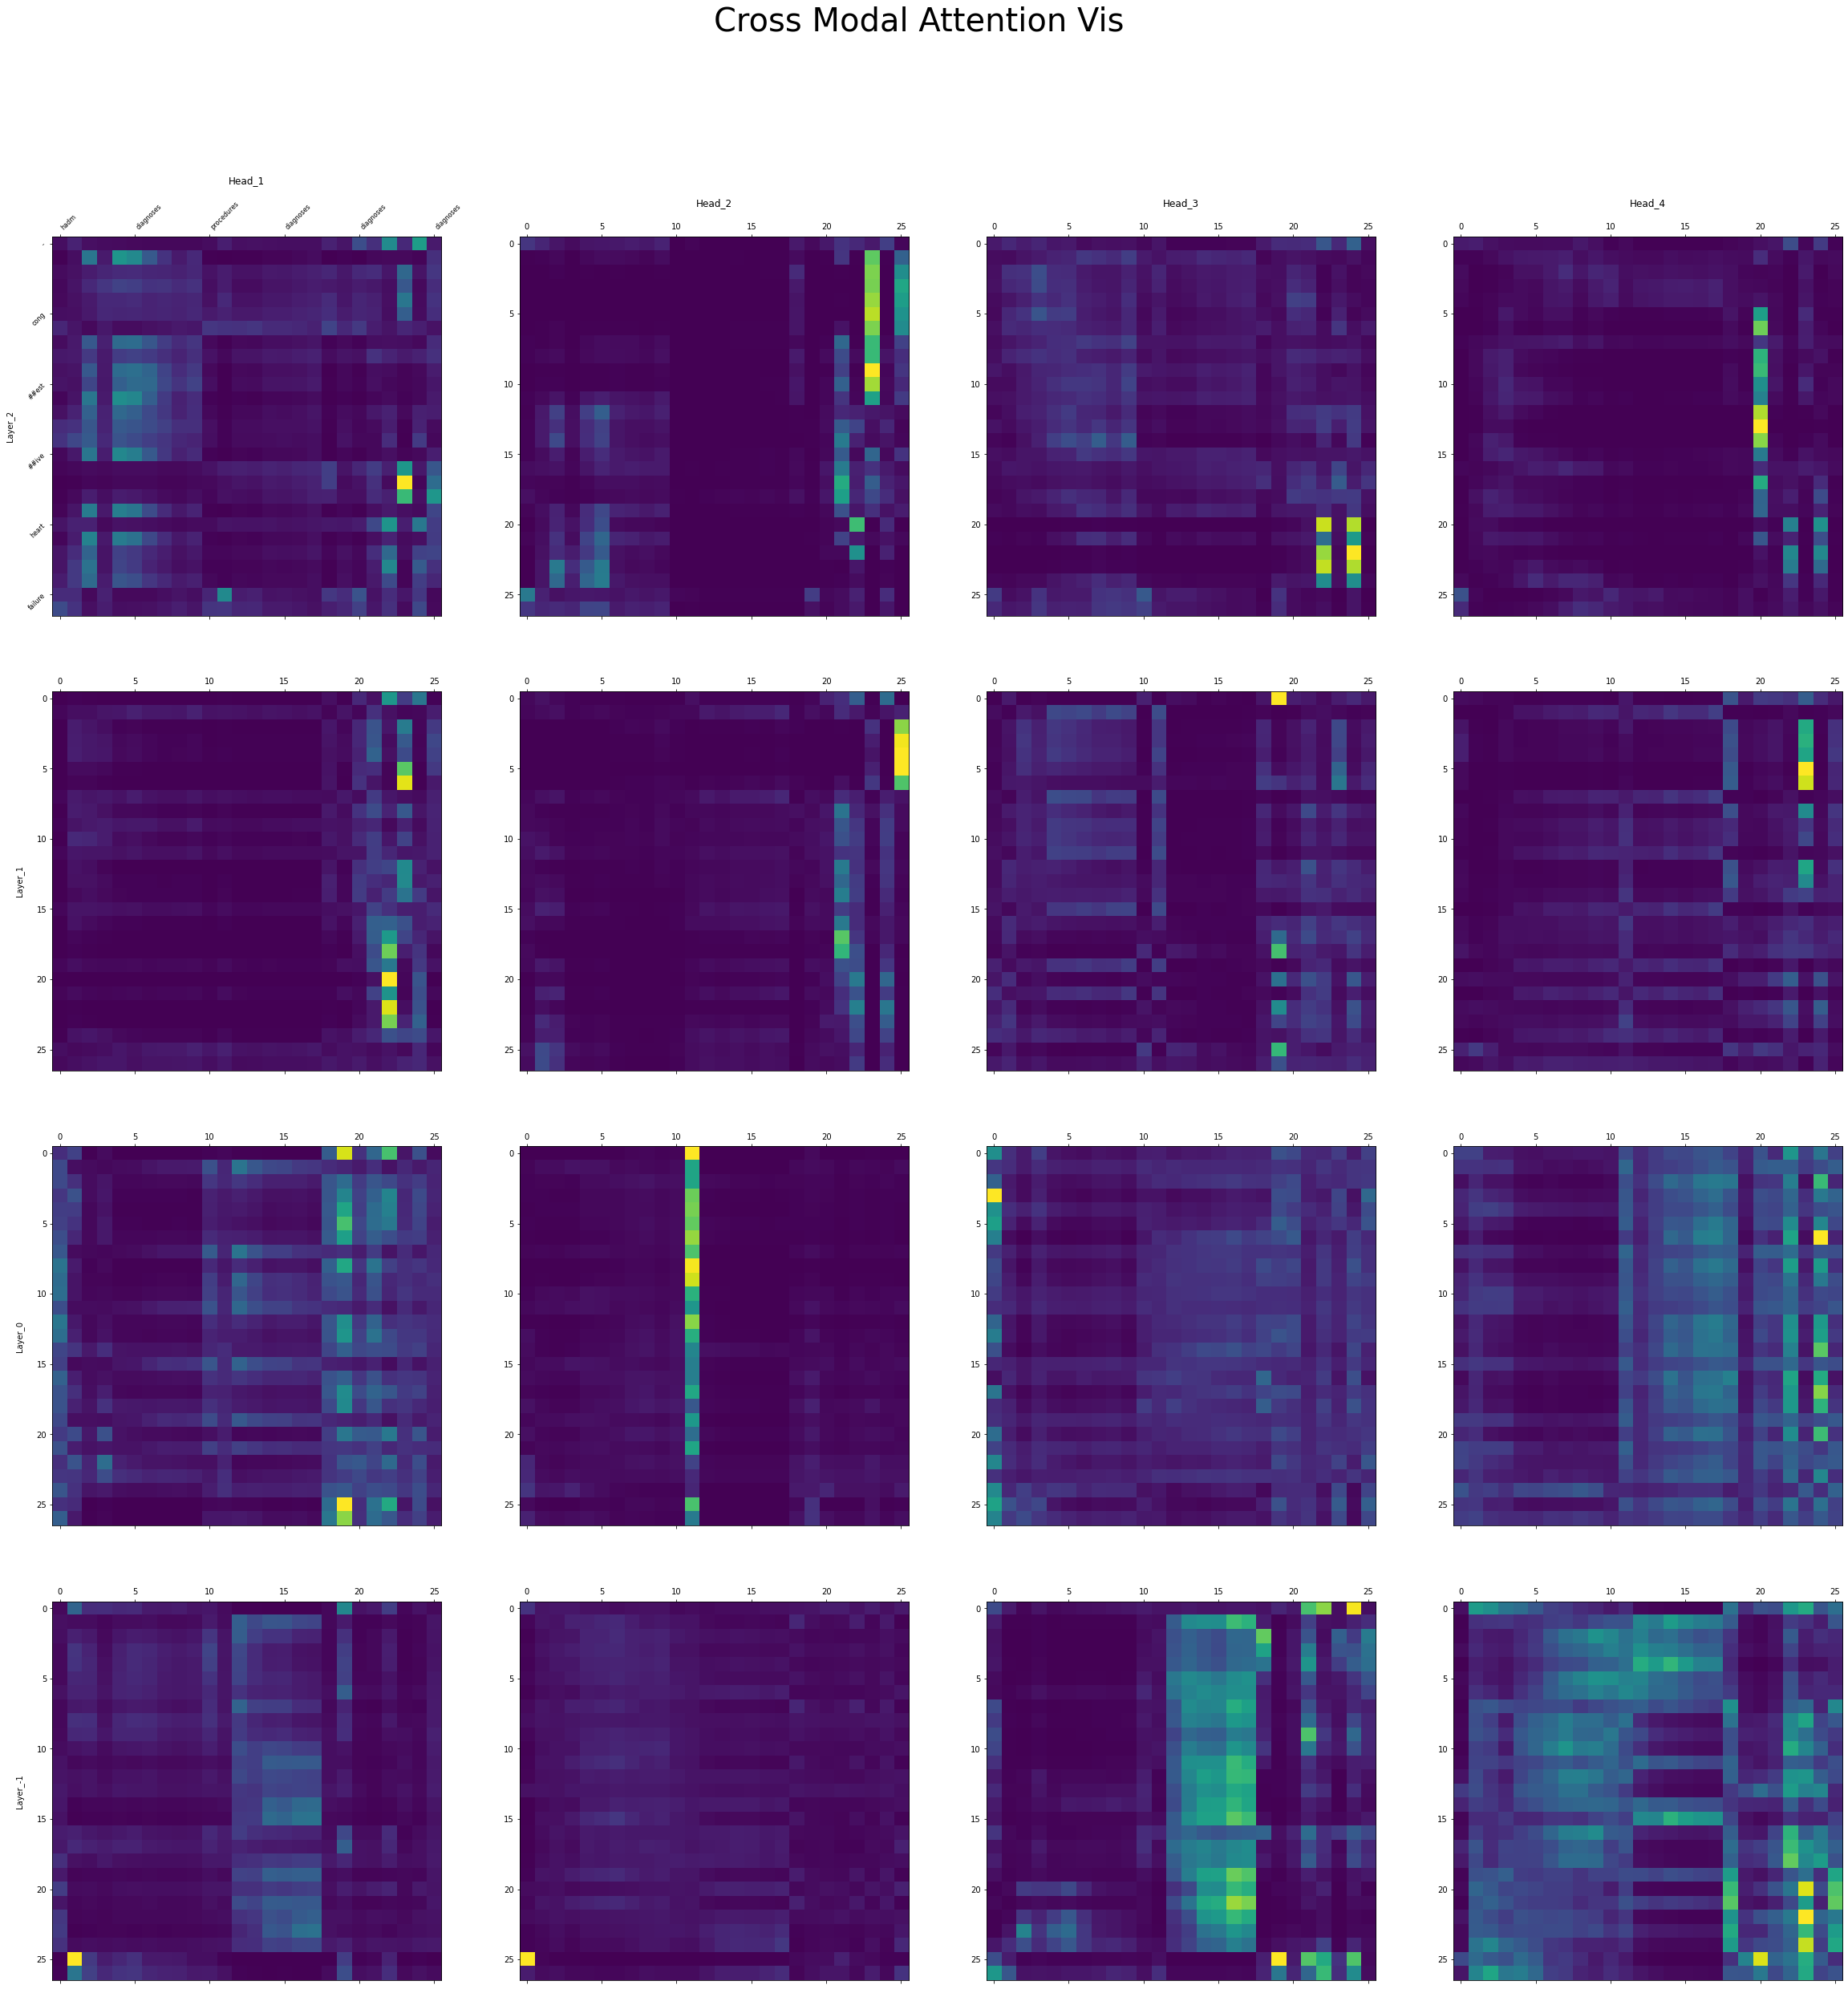

In [205]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(model.config.x_layers, model.config.num_attention_heads, figsize=(40,40))
for layer_idx in range(model.config.x_layers):
    for head_idx in range(model.config.num_attention_heads):
        axs[model.config.l_layers-1-layer_idx, head_idx].matshow(
            output_data['cross_encoder_attentions']['txt->kg'][layer_idx][0, head_idx,
                                                               :len(lang_tokens),:len(kg_tokens)].cpu().detach().numpy(),
#             cmap='gray',
        aspect='auto')
        #if (layer_idx == config.x_layers-1) and (head_idx==):
        if (layer_idx == 0) and (head_idx==0):
            axs[layer_idx, head_idx].set_xticklabels(kg_tokens, rotation='45',horizontalalignment='left', fontsize=8)
            axs[layer_idx, head_idx].set_yticklabels(lang_tokens, rotation='45',horizontalalignment='right', fontsize=8)
            axs[layer_idx, head_idx].set_xticks(range(len(kg_tokens)))
            axs[layer_idx, head_idx].set_yticks([range(len(lang_tokens))])
        axs[0, head_idx].set_title("Head_{}\n".format(head_idx+1))
    axs[layer_idx, 0].set_ylabel('Layer_{}\n'.format(model.config.l_layers-layer_idx))
plt.suptitle('Cross Modal Attention Vis', fontsize=40)

# Results 2: pick Retrieval sample

## base setting

In [5]:
EXP_PATH = '/home/ssbae/bae/kg_txt_multimodal/lxmert'
sys.path.append(EXP_PATH + '/src')

In [6]:
MODEL_PATH = 'KGenc_LMinit_H128_L2,2,4_Align_RC_Unified2000_RNG1234'

In [7]:
model_args = easydict.EasyDict({
    "model_name_or_path": os.path.join(EXP_PATH, f'pretrained_models/pretrained/binary_retrieval/dx,prx/{MODEL_PATH}'),
    "tokenizer_name": 'bert-base-uncased',
    "cache_dir": None,
})

data_args = easydict.EasyDict({
    "eval_data_file": os.path.join(EXP_PATH, "data/dx,prx_2000/dx,prx_UnifiedUniKGenc/valid"),
    "test_data_file": os.path.join(EXP_PATH, "data/dx,prx_2000/dx,prx_UnifiedUniKGenc/test"),
    "block_size": 512,
})

training_args = easydict.EasyDict({
    "per_device_eval_batch_size": 1,
    "task": "pretrain",
    "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
    "do_eval": True,
})

### load config, tokenizer, and model

In [8]:
config = LxmertConfig.from_pretrained(model_args.model_name_or_path, cache_dir=model_args.cache_dir)
config.use_ce_pooler = True
config.cross_att_type = 'cross'

In [9]:
tokenizer = LxmertTokenizer.from_pretrained(model_args.tokenizer_name, cache_dir=model_args.cache_dir)

In [10]:
# model = LxmertForKGTokPredAndMaskedLM.from_pretrained(model_args.model_name_or_path,
#                                                       config=config)

model = LxmertForRanking.from_pretrained(pretrained_model_name_or_path=model_args.model_name_or_path,
                                         config=config)

### load dataset, data_collator (test)

In [11]:
test_dataset = get_dataset(data_args, 
                           tokenizer=tokenizer, 
                           token_type_vocab=config.token_type_vocab,
                           test=True) if training_args.do_eval else None

100%|██████████| 2000/2000 [00:00<00:00, 154668.63it/s]


In [12]:
data_collator = Evaluation_DataCollator(tokenizer=tokenizer,
                                        kg_special_token_ids=config.kg_special_token_ids,
                                        task=training_args.task)

In [13]:
data_loader = DataLoader(
    test_dataset,
    sampler=SequentialSampler(test_dataset),
#     batch_size=training_args.eval_batch_size,
    batch_size=1,
    collate_fn=data_collator,
    pin_memory=True,
    )

### text retrieval

In [14]:
training_args.task = 'text_retrieval'

In [189]:
model.to(training_args.device)
# model.cpu()
model.eval()

LxmertForRanking(
  (lxmert): LxmertModel(
    (lang_embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(30522, 128)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (kg_embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(8057, 128)
      (position_embeddings): Embedding(1024, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LxmertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)


In [190]:
db = dict()
datas = [data for data in data_loader]

for k in datas[0]:
    db[k] = torch.cat([data[k] for data in datas]).to(training_args.device)

In [305]:
sample_idx = 1999

sample_hits = list()
sample_rank = list()

with torch.no_grad():
    for positive_idx in tqdm(range(len(test_dataset)), total=len(test_dataset)):
        if positive_idx == sample_idx:
        
            scores = list()
            for idx in range(len(test_dataset)//training_args.per_device_eval_batch_size+1):
                start_idx = idx*training_args.per_device_eval_batch_size
                if idx < (len(test_dataset)//training_args.per_device_eval_batch_size):
                    end_idx = (idx+1)*training_args.per_device_eval_batch_size
                else:
                    end_idx = len(test_dataset)
                if start_idx == end_idx:
                    continue

                inputs = dict()
                for k in db:
                    if training_args.task in ['text_retrieval', 'single_text_retrieval']:
                        if 'kg' in k:
                            inputs[k] = torch.stack([db[k][positive_idx]]*(end_idx-start_idx))
                        else:
                            inputs[k] = db[k][start_idx:end_idx]
                    else:
                        if 'kg' not in k:
                            inputs[k] = torch.stack([db[k][positive_idx]]*(end_idx-start_idx))
                        else:
                            inputs[k] = db[k][start_idx:end_idx]


                outputs = model(**inputs)
                
                if training_args.per_device_eval_batch_size == 1:
                    scores+=outputs.pooled_logits.unsqueeze(0)[:,1].tolist()
                else:
                    scores+=outputs.pooled_logits[:,1].tolist()

            ranks = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
        else:
            pass
        

100%|██████████| 2000/2000 [00:29<00:00, 68.50it/s]


In [306]:
ranks.index(sample_idx)

2

In [307]:
# original text
tokenizer.decode(db['lang_input_ids'][sample_idx], skip_special_tokens=True)

'congestive heart failure spinal stenosis bradycardia acute renal failure dm2 myelogram'

In [308]:
# the most relevant
for idx in range(10):
    print(idx+1, f'{scores[ranks[idx]]:.4f}')
    print(tokenizer.decode(db['lang_input_ids'][ranks[idx]], skip_special_tokens=True))
    print()

1 3.3523
gout chronic systolic congestive heart failure coronary artery disease insulin - dependent diabetes mellitus right internal jugular central line placement left elbow joint aspiration right knee joint aspiration

2 3.3163
primary diagnosis # congestive heart failure pulmonary hypertension # hypertensive, malignant # diabetes mellitus type 2, with complications uncontrolled. # chronic kidney disease stage 5 # initiation of hemodialysis. secondary diagnosis # hyperlipidemia # coronary artery disease hemodialysis x4

3 3.2716
congestive heart failure spinal stenosis bradycardia acute renal failure dm2 myelogram

4 3.0878
end - stage osteoarthritis / ddh l hip l thr

5 3.0298
anemia chronic kidney disease diabetes mellitus coronary artery disease none

6 3.0267
syncope coronary artery disease diabetes history of tia peripheral artery disease none

7 2.8125
syncope c2 and sternal fractures syndrome of inappropriate anti - diuretic hormone obstructive sleep apnea. diabetes mellitus i

In [309]:
# the most irrelevant
for idx in range(1999,1995, -1):
    print(idx+1, f'{scores[ranks[idx]]:.4f}')
    print(tokenizer.decode(db['lang_input_ids'][ranks[idx]], skip_special_tokens=True))
    print()

2000 -5.7194
cardiac arrest cardiogenic shock severe septic shock hypoxemic respiratory failure acute respiratory distress syndrome spontaneous bacterial peritonitis hepatorenal syndrome end stage liver disease from hepatitis c hepatic encephalopathy anemia central venous line placement cvvh paracentesis

1999 -5.6691
right lung empyema and esophageal - pleural fistula bilateral pleural effusions chronic respiratory failure requiring tracheostomy aspiration pneumonia flexible bronchoscopy egd peg placement and esophageal stent placement percutaneous tracheostomy right bacilic picc line ct - guided drainage rll collection

1998 -5.6477
mrsa empyema mrsa bactermia mrsa uti hepatitis c cirrhosis chest tube placement picc placement dobhoff tube placement

1997 -5.5298
spontaneous bacterial peritonitis. - hep b cirrhosis - advanced hepatocellular ca paracentesis x 4



In [312]:
# dx,prx relations = 8

[id2node[n_id.item()] for n_id in db['kg_input_ids'][sample_idx] \
if n_id not in range(config.num_relations+1)]

[(n_id.item(), id2node[n_id.item()]) for n_id in db['kg_input_ids'][sample_idx] if n_id > 0]

[(2, 'CLS'),
 (3, 'hadm'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (7, 'procedures'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (5, 'diagnoses'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (6, 'procedures_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (4, 'diagnoses_icd9_code'),
 (7461,
  '"hypertensive chronic kidney disease, unspecified, with chronic kidney disease stage v or end stage renal disease"'),
 (6588, '"asthma, unspecif

# Graph Retrieval

In [18]:
training_args.task = 'graph_retrieval'

In [21]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
training_args.device = 'cuda:0'

In [19]:
model.to(training_args.device)
# model.cpu()
model.eval()

LxmertForRanking(
  (lxmert): LxmertModel(
    (lang_embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(30522, 128)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (kg_embeddings): LxmertEmbeddings(
      (word_embeddings): Embedding(8057, 128)
      (position_embeddings): Embedding(1024, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LxmertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)


### load label dictionary in KG

In [34]:
node2id = torch.load(os.path.join(os.path.dirname(data_args.test_data_file), 'unified_node'))
id2node = {v:k.split('^^')[0] for k,v in node2id.items()}

In [29]:
for idx in range(2000):
    output = tokenizer.decode(db['lang_input_ids'][idx], skip_special_tokens=True)
    if 'full thickness defect flail left knee' in output:
        print(idx)

999


In [17]:
db = dict()
datas = [data for data in data_loader]

for k in datas[0]:
    db[k] = torch.cat([data[k] for data in datas]).to(training_args.device)
    # db[k] = torch.cat([data[k] for data in datas]).cpu()

In [30]:
sample_idx = 999

sample_hits = list()
sample_rank = list()

with torch.no_grad():
    for positive_idx in tqdm(range(len(test_dataset)), total=len(test_dataset)):
        if positive_idx == sample_idx:
        
            scores = list()
            for idx in range(len(test_dataset)//training_args.per_device_eval_batch_size+1):
                start_idx = idx*training_args.per_device_eval_batch_size
                if idx < (len(test_dataset)//training_args.per_device_eval_batch_size):
                    end_idx = (idx+1)*training_args.per_device_eval_batch_size
                else:
                    end_idx = len(test_dataset)
                if start_idx == end_idx:
                    continue

                inputs = dict()
                for k in db:
                    if training_args.task in ['text_retrieval', 'single_text_retrieval']:
                        if 'kg' in k:
                            inputs[k] = torch.stack([db[k][positive_idx]]*(end_idx-start_idx))
                        else:
                            inputs[k] = db[k][start_idx:end_idx]
                    else:
                        if 'kg' not in k:
                            inputs[k] = torch.stack([db[k][positive_idx]]*(end_idx-start_idx))
                        else:
                            inputs[k] = db[k][start_idx:end_idx]


                outputs = model(**inputs)
                
                if training_args.per_device_eval_batch_size == 1:
                    scores+=outputs.pooled_logits.unsqueeze(0)[:,1].tolist()
                else:
                    scores+=outputs.pooled_logits[:,1].tolist()

            ranks = sorted(range(len(scores)), key=lambda k: scores[k], reverse=True)
        else:
            pass
        

100%|██████████| 2000/2000 [00:31<00:00, 63.66it/s]


In [31]:
ranks.index(sample_idx)

2

In [32]:
# Query: text
tokenizer.decode(db['lang_input_ids'][sample_idx][:sum(db['lang_input_ids'][sample_idx].not_equal(0))])

'[CLS] removal of antibiotic spacers, irrigation and debridement left knee irrigation and debridement of left heel ulcer excision of left knee eschar with closure of full thickness defect flail left knee [SEP] removal of antibiotic spacers, irrigation and debridement left knee, excision and primary closure of full thickness left knee eschar irrigation and debridement of left heel ulcer [SEP]'

In [35]:
# original paired graph
org_graph = [id2node[n_id.item()] for n_id in db['kg_input_ids'][sample_idx] \
             if n_id not in range(config.num_relations+1)]
org_graph_raw = [n_id.item() for n_id in db['kg_input_ids'][sample_idx] \
             if n_id not in range(config.num_relations+1)]
print(org_graph)

['"infection and inflammatory reaction due to internal joint prosthesis"', '"other iatrogenic hypotension"', '"venous catheterization, not elsewhere classified"', '"removal of (cement) spacer"', '"systolic heart failure, unspecified"', '"acute posthemorrhagic anemia"', '"pressure ulcer, heel"', '"unspecified essential hypertension"', '"congestive heart failure, unspecified"', '"pressure ulcer, lower back"', '"excisional debridement of wound, infection, or burn"', '"knee joint replacement"', '"unspecified acquired hypothyroidism"', '"synovectomy, knee"']


In [39]:
# the most relevant graph
for idx in range(5):
    print(idx+1, f'[CLS] score: {scores[ranks[idx]]:.4f}')
    retrieved_graph = [id2node[n_id.item()] for n_id in db['kg_input_ids'][ranks[idx]] \
                       if n_id not in range(config.num_relations+1)]
    retrieved_graph_raw = [n_id.item() for n_id in db['kg_input_ids'][ranks[idx]] \
                       if n_id not in range(config.num_relations+1)]
    
    node_sim = len([n_id for n_id in retrieved_graph_raw if n_id in org_graph_raw]) / len(org_graph_raw)
    node222 = [id2node[n_id] for n_id in retrieved_graph_raw if n_id in org_graph_raw]
    print(f'naive_sim_score: {node_sim*100:.0f}%')
    print(retrieved_graph)
    print(node222)
    print()

1 [CLS] score: 4.5049
naive_sim_score: 14%
['"acute osteomyelitis, ankle and foot"', '"asthma, unspecified type, unspecified"', '"ulcer of heel and midfoot"', '"diabetes with other specified manifestations, type i [juvenile type], not stated as uncontrolled"', '"long-term (current) use of insulin"', '"methicillin susceptible staphylococcus aureus in conditions classified elsewhere and of unspecified site"', '"streptococcus infection in conditions classified elsewhere and of unspecified site, streptococcus, group b"', '"excisional debridement of wound, infection, or burn"', '"family history of diabetes mellitus"', '"gangrene"', '"nonexcisional debridement of wound, infection or burn"', '"cellulitis and abscess of foot, except toes"', '"venous catheterization, not elsewhere classified"', '"esophageal reflux"', '"other bone involvement in diseases classified elsewhere"', '"amputation of toe"', '"irritable bowel syndrome"', '"amputation of toe"']
['"excisional debridement of wound, infecti

In [40]:
# the most irrelevant graph
for idx in range(1999,1995, -1):
    print(idx+1, f'[CLS] score: {scores[ranks[idx]]:.4f}')
    retrieved_graph = [id2node[n_id.item()] for n_id in db['kg_input_ids'][ranks[idx]] \
                       if n_id not in range(config.num_relations+1)]
    retrieved_graph_raw = [n_id.item() for n_id in db['kg_input_ids'][ranks[idx]] \
                       if n_id not in range(config.num_relations+1)]
    
    node_sim = len([n_id for n_id in retrieved_graph_raw if n_id in org_graph_raw]) / len(org_graph_raw)
    print(f'naive_sim_score: {node_sim*100:.0f}%')
    print(retrieved_graph)
    print()

2000 [CLS] score: -6.4434
naive_sim_score: 0%
['"localization-related (focal) (partial) epilepsy and epileptic syndromes with complex partial seizures, with intractable epilepsy"', '"lobectomy of brain"']

1999 [CLS] score: -6.4375
naive_sim_score: 14%
['"esophageal varices in diseases classified elsewhere, with bleeding"', '"acute alcoholic hepatitis"', '"percutaneous abdominal drainage"', '"unspecified acquired hypothyroidism"', '"endoscopic excision or destruction of lesion or tissue of esophagus"', '"urinary tract infection, site not specified"', '"alcoholic cirrhosis of liver"', '"alcohol abuse, continuous"', '"pneumonia, organism unspecified"', '"unspecified essential hypertension"', '"alcohol withdrawal"']

1998 [CLS] score: -6.4141
naive_sim_score: 0%
['"arteriography of cerebral arteries"', '"acidosis"', '"intracranial pressure monitoring"', '"street and highway accidents"', '"enteral infusion of concentrated nutritional substances"', '"open wound of buttock, without mention o